In [1]:
import torch
import wandb
import numpy as np
import random
from scipy import stats
import time
from torch.distributions.multivariate_normal import MultivariateNormal
from pingouin import multivariate_normality

from training_helpers import *
from nf_mctm import *

In [2]:
def set_seeds(seed_int):
    # Reproducibility
    # Infos from here: https://pytorch.org/docs/stable/notes/randomness.html
    # Set Seeds for Torch, Numpy and Python
    torch.manual_seed(seed_int)
    np.random.seed(seed_int)
    random.seed(seed_int)

In [3]:
def create_data(sample_num=2000):
    loc = torch.zeros(3)
    lam = torch.Tensor([[1, 0, 0],
                        [3, 1, 0],
                        [0, 0, 1]])
    scale = lam @ torch.eye(3) @ torch.transpose(lam, 0, 1)
    y_distribution = MultivariateNormal(loc, scale)
    y = y_distribution.sample((sample_num, 1))  # Generate training data
    log_likelihood = y_distribution.log_prob(y)
    y = y.reshape((sample_num, 3))

    return y,log_likelihood

In [4]:
def evaluate_latent_space(z):
    # https://www.statology.org/multivariate-normality-test-r/
    # https://github.com/raphaelvallat/pingouin/blob/master/pingouin/multivariate.py
    # https://www.math.kit.edu/stoch/~henze/seite/aiwz/media/tests-mvn-test-2020.pdf
    res = multivariate_normality(z, alpha=.05)
    k2, p  = stats.normaltest(z)

    return res.normal, res.pval, np.mean(z,0), np.cov(z,rowvar=False), p


In [5]:
from itertools import combinations

def density_plots(data):
    num_cols = data.shape[1]
    fig, axs = plt.subplots(nrows=1, ncols=num_cols, figsize=(15,5),
                            gridspec_kw={'wspace':0.0, 'hspace':0.0},sharey=True)
    a=0
    for i, j in combinations(range(num_cols), 2):
        if i != j:
            sns.kdeplot(ax=axs[a], x=data[:, j], y=data[:, i])
            a+=1
    plt.subplots_adjust(wspace=0.05)

    return fig

def plot_latent_space(z):
    fig = density_plots(z)
    return fig

In [6]:
def simulation_study(config=None):
    ##
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        set_seeds(config.seed)

        y, train_likelihood = create_data(2000)

        if config.normalisation_layer == None:
            poly_range= torch.tensor([[-15], [15]])
        else:
            poly_range= torch.tensor([[-8], [8]])

        wandb.log({"poly_range": poly_range})

        nf_mctm = NF_MCTM(input_min=y.min(0).values,
                          input_max=y.max(0).values,
                          polynomial_range=poly_range,
                          number_variables=3,
                          spline_decorrelation="bspline",
                          normalisation_layer=config.normalisation_layer)

        #no epochs required
        iterations_max = 1000
        wandb.log({"iterations_max": iterations_max})
        start = time.time()
        train(model=nf_mctm,
              train_data=y,
              iterations=iterations_max,
              verbose=False)
        end = time.time()

        wandb.log({"runtime": end-start})

        z = nf_mctm.forward(y,train=False).detach().numpy()

        res_normal, res_pval, z_mean, z_cov, p = evaluate_latent_space(z)
        wandb.log({"mv_normality_result": res_normal})
        wandb.log({"mv_normality_pval": res_pval})
        wandb.log({"z_means": z_mean})
        wandb.log({"z_cov": z_cov})
        wandb.log({"uv_normality_pvals": p})

        fig = plot_latent_space(z)
        wandb.log({"plot": wandb.Image(fig)})

        #wandb.log({"seed": config.seed})

100%|██████████| 1000/1000 [01:15<00:00, 13.33it/s]


75.08459687232971
False
3.11821110143263e-173
[-0.00092081  0.03699958 -0.10783401]
[[ 0.9971952   0.01071545 -0.2214163 ]
 [ 0.01071545  1.02416875 -0.14511623]
 [-0.2214163  -0.14511623  7.15267386]]
[0.66750363 0.58180274 0.        ]
Figure(1500x500)


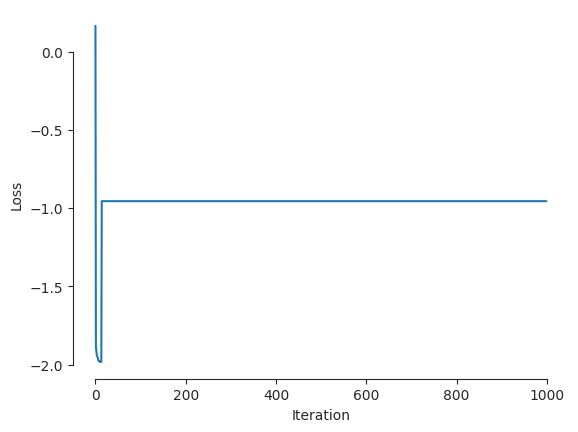

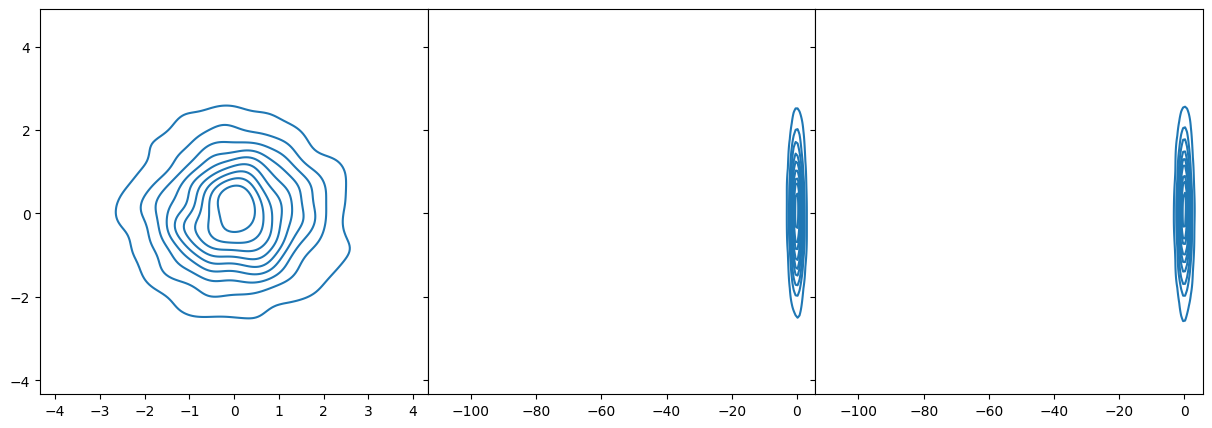

In [7]:
set_seeds(6)

y, train_likelihood = create_data(2000)

nl=None

nf_mctm = NF_MCTM(input_min=y.min(0).values,
                  input_max=y.max(0).values,
                  polynomial_range=torch.tensor([[-15], [15]]),
                  number_variables=3,
                  spline_decorrelation="bspline",
                  normalisation_layer=nl)

#no epochs required
start = time.time()
train(model=nf_mctm,
      train_data=y,
      learning_rate=1,
      iterations=1000,
      verbose=False)
end = time.time()

print(end-start)

z = nf_mctm.forward(y,train=False).detach().numpy()

res_normal, res_pval, z_mean, z_cov, p = evaluate_latent_space(z)
print(res_normal)
print(res_pval)
print(z_mean)
print(z_cov)
print(p)


fig = plot_latent_space(z)
print(fig)

 79%|███████▉  | 158/200 [01:34<00:25,  1.68it/s]

Early Stop!
94.10549569129944


True
0.581401130772042
[0.00531164 0.00202366 0.00137603]
[[ 9.88932857e-01 -6.74892052e-04  1.07932633e-04]
 [-6.74892052e-04  1.00131307e+00  1.51119463e-03]
 [ 1.07932633e-04  1.51119463e-03  1.00212517e+00]]
[0.57611067 0.46742147 0.97150143]
Figure(1500x500)


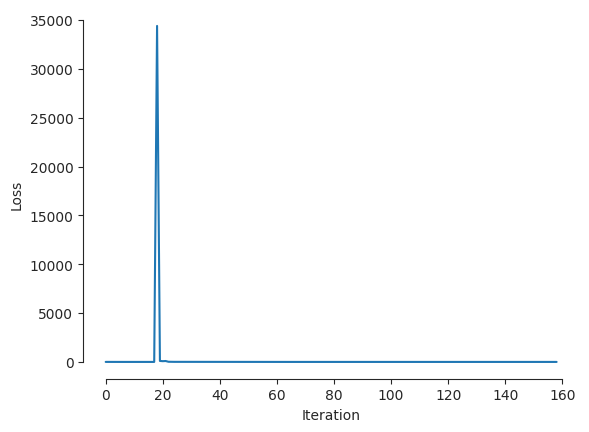

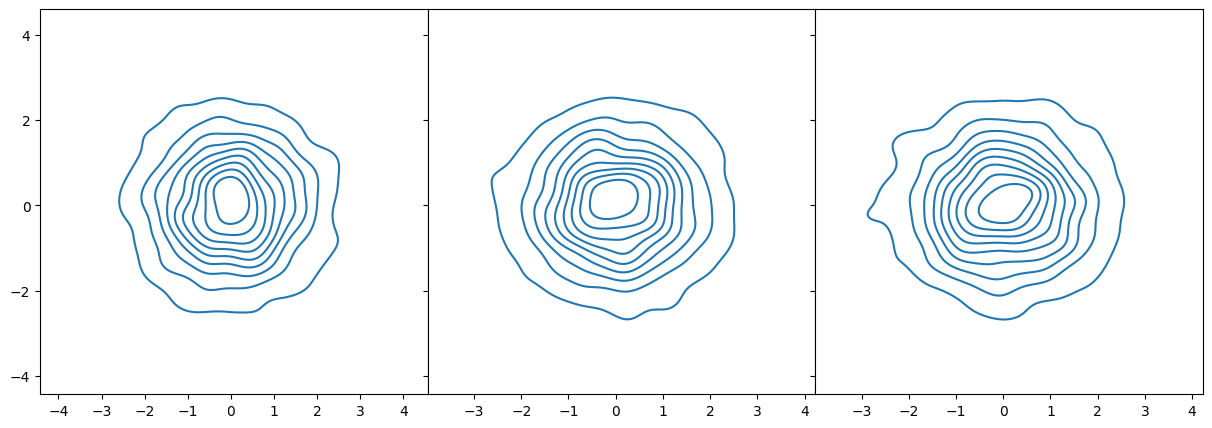

In [10]:
set_seeds(6)

y, train_likelihood = create_data(2000)

nl=None

nf_mctm = NF_MCTM(input_min=y.min(0).values,
                  input_max=y.max(0).values,
                  polynomial_range=torch.tensor([[-15], [15]]),
                  number_variables=3,
                  spline_decorrelation="bspline",
                  normalisation_layer=nl)

#no epochs required
start = time.time()
train(model=nf_mctm,
      train_data=y,
      learning_rate=0.5,
      iterations=200,
      verbose=False)
end = time.time()

print(end-start)

z = nf_mctm.forward(y,train=False).detach().numpy()

res_normal, res_pval, z_mean, z_cov, p = evaluate_latent_space(z)
print(res_normal)
print(res_pval)
print(z_mean)
print(z_cov)
print(p)


fig = plot_latent_space(z)
print(fig)

100%|██████████| 200/200 [01:28<00:00,  2.27it/s]


88.08509111404419
True
0.24400650276682978
[ 0.00882965  0.00289404 -0.00615637]
[[ 1.01483698  0.00217019 -0.00528588]
 [ 0.00217019  0.99350221  0.00271071]
 [-0.00528588  0.00271071  1.03553254]]
[1.38889205e-04 5.29674273e-01 2.11683797e-08]
Figure(1500x500)


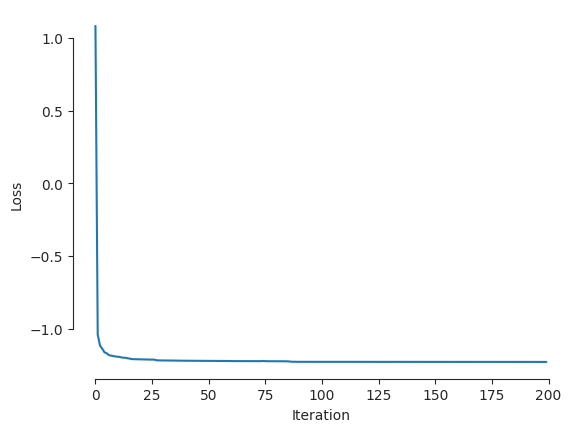

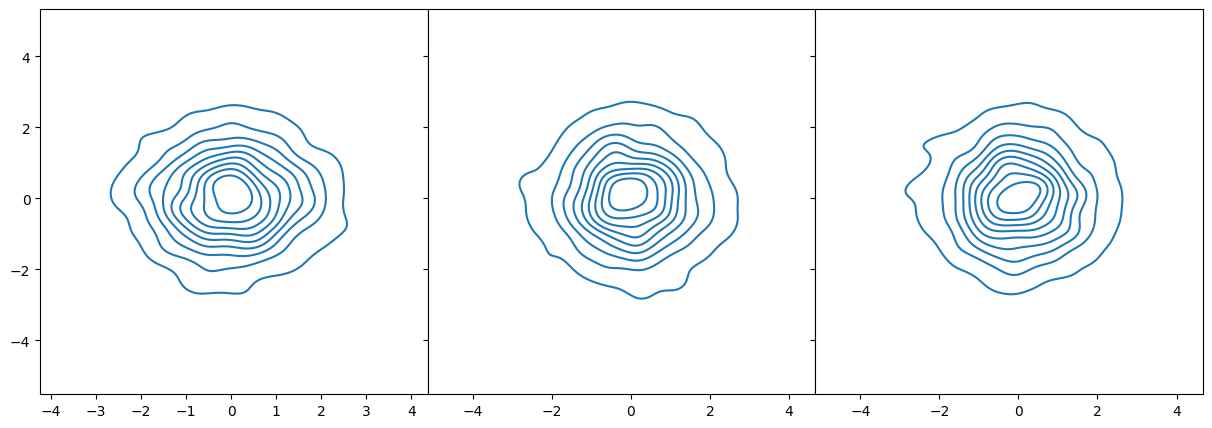

In [11]:
set_seeds(6)

y, train_likelihood = create_data(2000)

nl="bounding"

nf_mctm = NF_MCTM(input_min=y.min(0).values,
                  input_max=y.max(0).values,
                  polynomial_range=torch.tensor([[-10], [10]]),
                  number_variables=3,
                  spline_decorrelation="bspline",
                  normalisation_layer=nl)

#no epochs required
start = time.time()
train(model=nf_mctm,
      train_data=y,
      learning_rate=0.5,
      iterations=200,
      verbose=False)
end = time.time()

print(end-start)

z = nf_mctm.forward(y,train=False).detach().numpy()

res_normal, res_pval, z_mean, z_cov, p = evaluate_latent_space(z)
print(res_normal)
print(res_pval)
print(z_mean)
print(z_cov)
print(p)


fig = plot_latent_space(z)
print(fig)

100%|██████████| 200/200 [01:21<00:00,  2.45it/s]


81.82592606544495
False
0.019857165922121847
[ 0.03431081  0.01118725 -0.0017576 ]
[[ 1.03598724e+00  1.70742008e-02  6.66809202e-04]
 [ 1.70742008e-02  8.81182981e-01 -7.58765434e-04]
 [ 6.66809202e-04 -7.58765434e-04  1.01131518e+00]]
[1.12125160e-04 5.46543512e-01 2.10938603e-03]
Figure(1500x500)


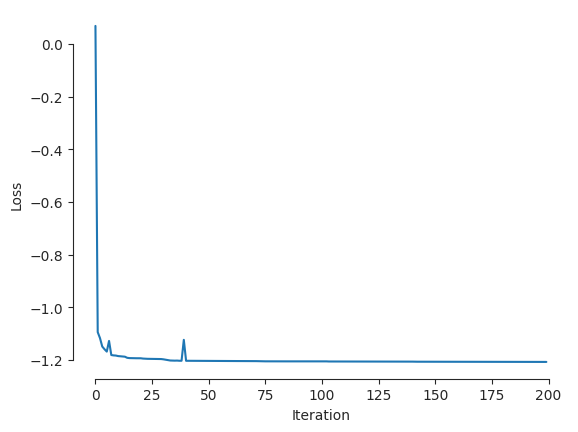

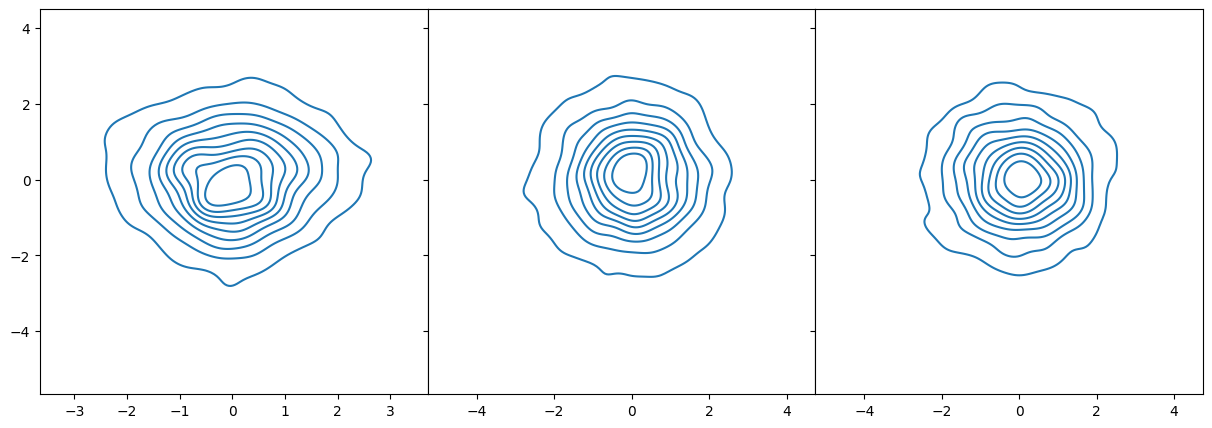

In [14]:
set_seeds(9)

y, train_likelihood = create_data(2000)

nl="bounding"

nf_mctm = NF_MCTM(input_min=y.min(0).values,
                  input_max=y.max(0).values,
                  polynomial_range=torch.tensor([[-8], [8]]),
                  number_variables=3,
                  spline_decorrelation="bspline",
                  normalisation_layer=nl)

#no epochs required
start = time.time()
train(model=nf_mctm,
      train_data=y,
      learning_rate=0.5,
      iterations=200,
      verbose=False)
end = time.time()

print(end-start)

z = nf_mctm.forward(y,train=False).detach().numpy()

res_normal, res_pval, z_mean, z_cov, p = evaluate_latent_space(z)
print(res_normal)
print(res_pval)
print(z_mean)
print(z_cov)
print(p)


fig = plot_latent_space(z)
print(fig)

 48%|████▊     | 480/1000 [02:39<02:53,  3.00it/s]

Early Stop!
160.00829410552979


True
0.10846965032637146
[0.02804977 0.01048001 0.00024551]
[[ 1.01784741e+00  7.32753590e-03 -3.70943629e-04]
 [ 7.32753590e-03  9.33605915e-01  1.59983940e-04]
 [-3.70943629e-04  1.59983940e-04  1.00787888e+00]]
[5.03266898e-04 5.27701577e-01 1.21075203e-02]
Figure(1500x500)


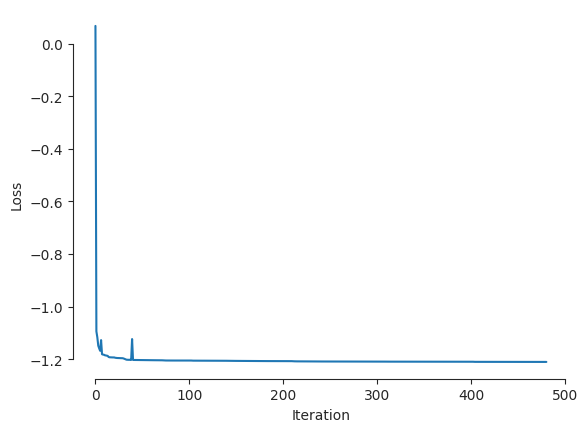

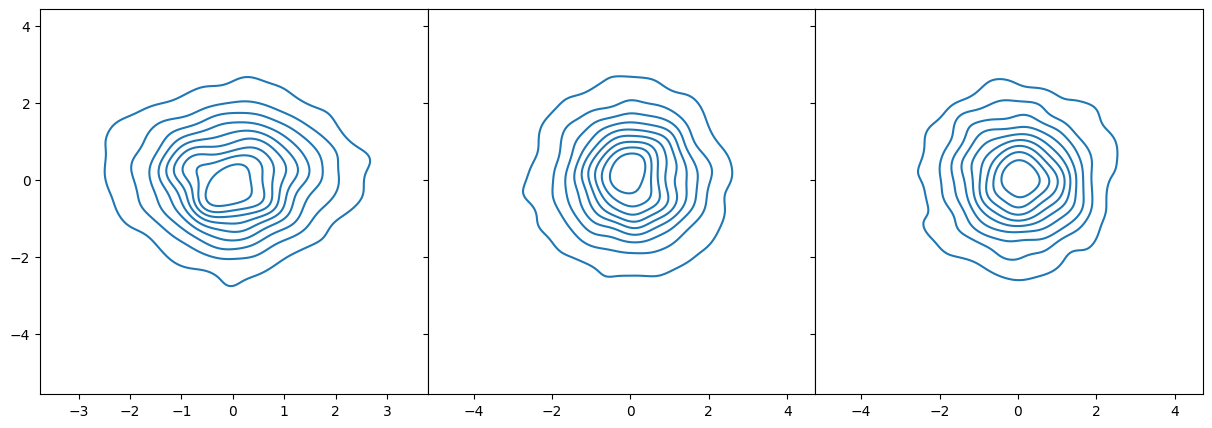

In [15]:
set_seeds(9)

y, train_likelihood = create_data(2000)

nl="bounding"

nf_mctm = NF_MCTM(input_min=y.min(0).values,
                  input_max=y.max(0).values,
                  polynomial_range=torch.tensor([[-8], [8]]),
                  number_variables=3,
                  spline_decorrelation="bspline",
                  normalisation_layer=nl)

#no epochs required
start = time.time()
train(model=nf_mctm,
      train_data=y,
      learning_rate=0.5,
      iterations=1000,
      verbose=False)
end = time.time()

print(end-start)

z = nf_mctm.forward(y,train=False).detach().numpy()

res_normal, res_pval, z_mean, z_cov, p = evaluate_latent_space(z)
print(res_normal)
print(res_pval)
print(z_mean)
print(z_cov)
print(p)


fig = plot_latent_space(z)
print(fig)

 99%|█████████▉| 992/1000 [04:34<00:02,  3.61it/s]


Early Stop!
274.8875288963318
True
0.3835419954848945
[0.02075081 0.00887295 0.00074294]
[[1.00759797e+00 5.87806677e-03 1.49256825e-03]
 [5.87806677e-03 9.62348408e-01 5.84889613e-04]
 [1.49256825e-03 5.84889613e-04 1.00520523e+00]]
[0.00487664 0.42498893 0.0795071 ]
Figure(1500x500)


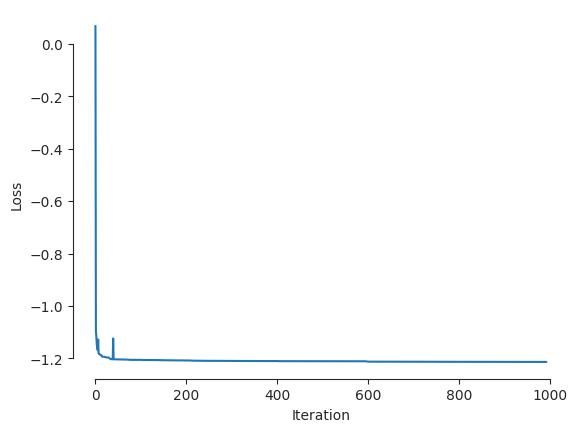

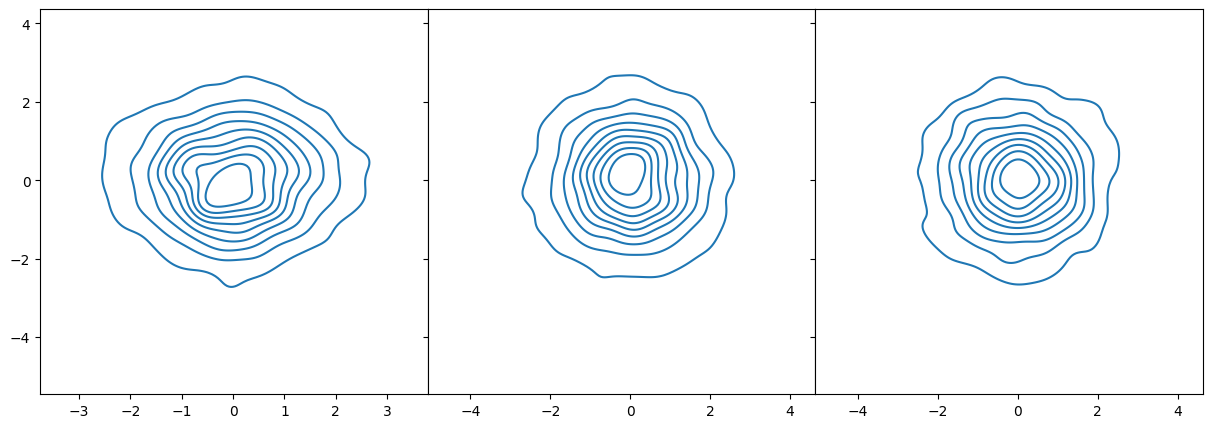

In [16]:
set_seeds(9)

y, train_likelihood = create_data(2000)

nl="bounding"

nf_mctm = NF_MCTM(input_min=y.min(0).values,
                  input_max=y.max(0).values,
                  polynomial_range=torch.tensor([[-8], [8]]),
                  number_variables=3,
                  spline_decorrelation="bspline",
                  normalisation_layer=nl)

#no epochs required
start = time.time()
train(model=nf_mctm,
      train_data=y,
      learning_rate=0.5,
      iterations=1000,
      patience=10,
      min_delta=1e-9,
      verbose=False)
end = time.time()

print(end-start)

z = nf_mctm.forward(y,train=False).detach().numpy()

res_normal, res_pval, z_mean, z_cov, p = evaluate_latent_space(z)
print(res_normal)
print(res_pval)
print(z_mean)
print(z_cov)
print(p)


fig = plot_latent_space(z)
print(fig)

100%|██████████| 1000/1000 [06:06<00:00,  2.73it/s]


366.8101544380188
False
2.184647228407751e-08
[0.0424695  0.01280923 0.0026578 ]
[[ 9.82239260e-01  2.31055981e-02 -8.28914105e-03]
 [ 2.31055981e-02  8.41042692e-01 -9.84679337e-04]
 [-8.28914105e-03 -9.84679337e-04  9.93002357e-01]]
[0.00048721 0.17545984 0.18025673]
Figure(1500x500)


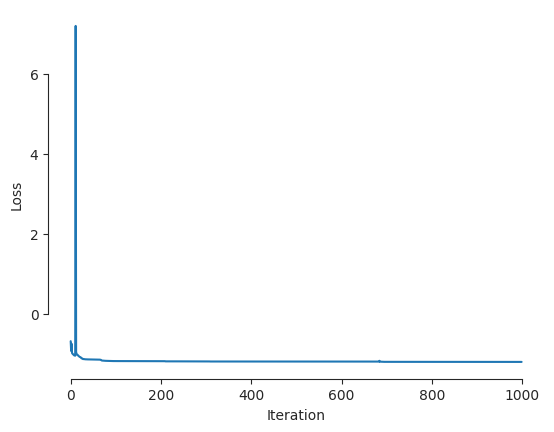

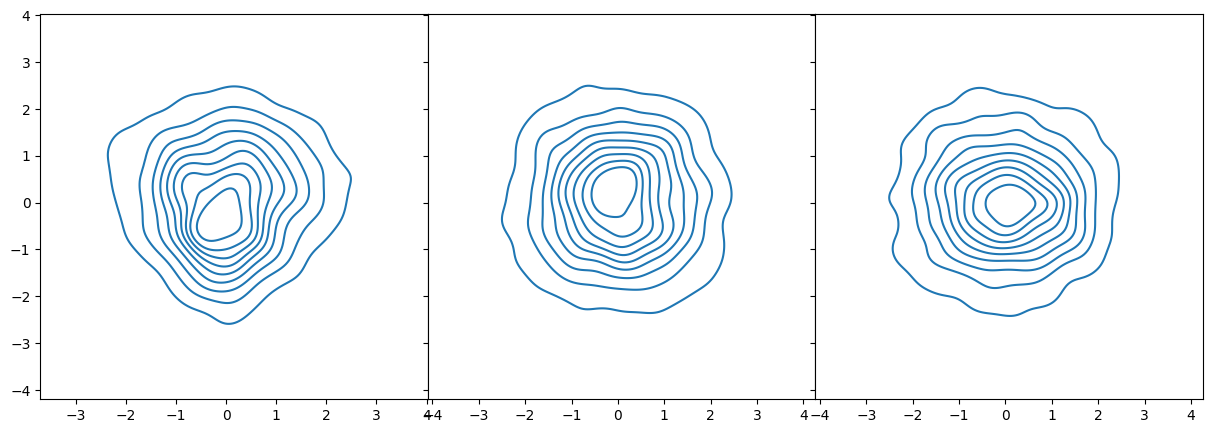

In [17]:
set_seeds(9)

y, train_likelihood = create_data(2000)

nl="bounding"

nf_mctm = NF_MCTM(input_min=y.min(0).values,
                  input_max=y.max(0).values,
                  polynomial_range=torch.tensor([[-4], [4]]),
                  number_variables=3,
                  spline_decorrelation="bspline",
                  normalisation_layer=nl)

#no epochs required
start = time.time()
train(model=nf_mctm,
      train_data=y,
      learning_rate=0.5,
      iterations=1000,
      patience=10,
      min_delta=1e-9,
      verbose=False)
end = time.time()

print(end-start)

z = nf_mctm.forward(y,train=False).detach().numpy()

res_normal, res_pval, z_mean, z_cov, p = evaluate_latent_space(z)
print(res_normal)
print(res_pval)
print(z_mean)
print(z_cov)
print(p)


fig = plot_latent_space(z)
print(fig)

100%|██████████| 1000/1000 [07:16<00:00,  2.29it/s]


436.8016119003296
False
1.044482443433957e-42
[-0.06642366 -0.02472462 -0.02252347]
[[ 0.7822812   0.07293754 -0.1178159 ]
 [ 0.07293754  0.18431169  0.00176003]
 [-0.1178159   0.00176003  0.97605108]]
[1.90779162e-001 1.11778092e-116 2.53578029e-002]
Figure(1500x500)


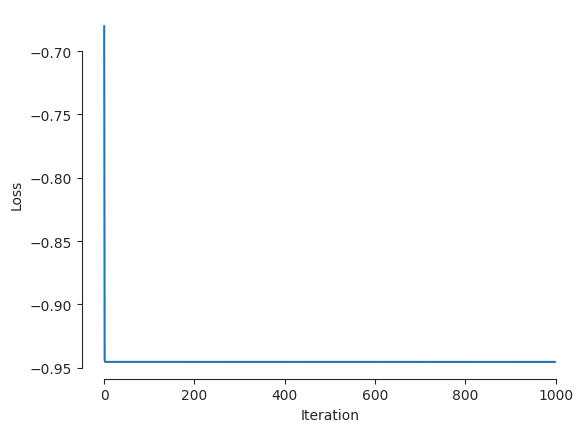

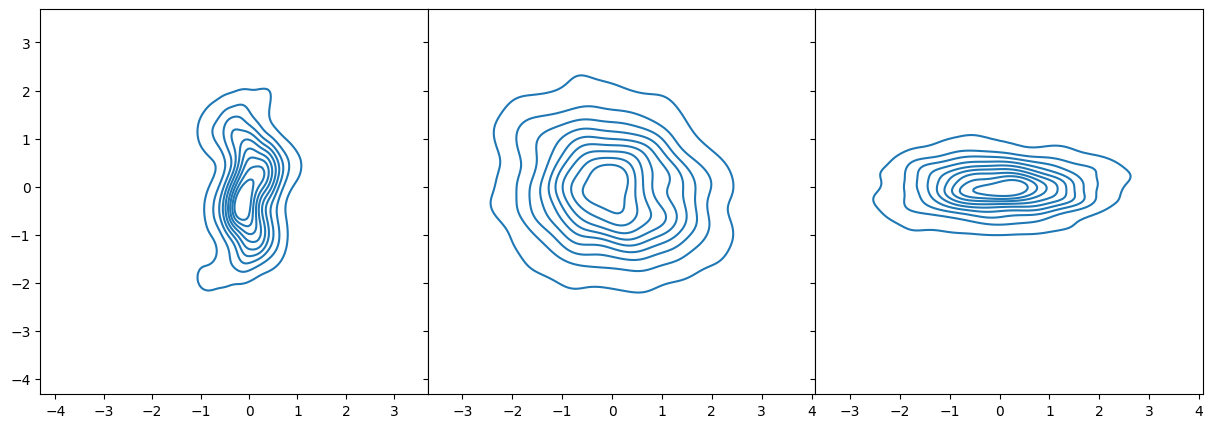

In [21]:
set_seeds(9)

y, train_likelihood = create_data(2000)

nl="bounding"

nf_mctm = NF_MCTM(input_min=y.min(0).values,
                  input_max=y.max(0).values,
                  polynomial_range=torch.tensor([[-4], [4]]),
                  number_variables=3,
                  spline_decorrelation="bspline",
                  normalisation_layer=nl)

#no epochs required
start = time.time()
train(model=nf_mctm,
      train_data=y,
      learning_rate=1,
      iterations=1000,
      patience=10,
      min_delta=1e-7,
      verbose=False)
end = time.time()

print(end-start)

z = nf_mctm.forward(y,train=False).detach().numpy()

res_normal, res_pval, z_mean, z_cov, p = evaluate_latent_space(z)
print(res_normal)
print(res_pval)
print(z_mean)
print(z_cov)
print(p)


fig = plot_latent_space(z)
print(fig)

 14%|█▍        | 1394/10000 [08:46<54:12,  2.65it/s]  


Early Stop!
526.8130760192871
False
1.3163479726307362e-08
[0.06479198 0.01797818 0.00316816]
[[ 1.00453826  0.04497495  0.00115713]
 [ 0.04497495  0.77272321 -0.0014004 ]
 [ 0.00115713 -0.0014004   0.98490623]]
[0.000949   0.01098    0.22656718]
Figure(1500x500)


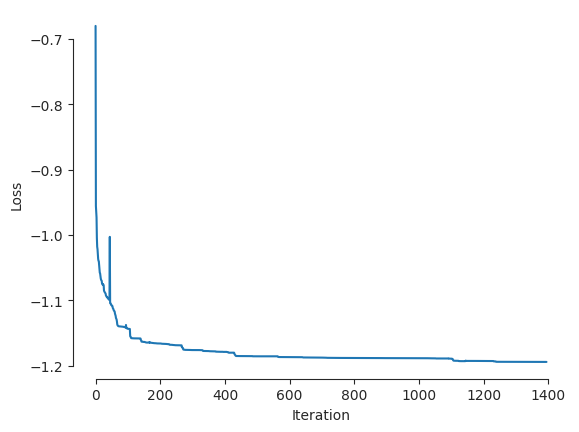

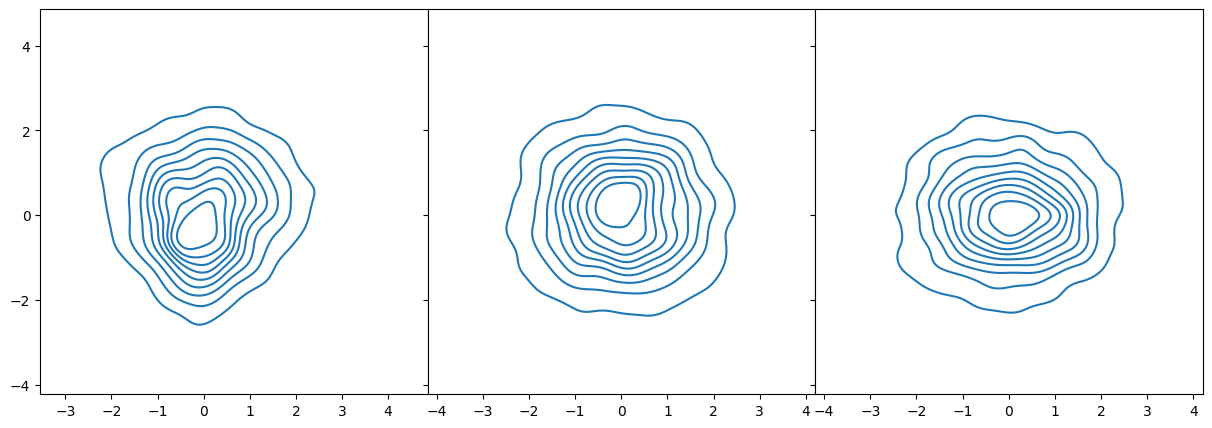

In [23]:
set_seeds(9)

y, train_likelihood = create_data(2000)

nl="bounding"

nf_mctm = NF_MCTM(input_min=y.min(0).values,
                  input_max=y.max(0).values,
                  polynomial_range=torch.tensor([[-4], [4]]),
                  number_variables=3,
                  spline_decorrelation="bspline",
                  normalisation_layer=nl)

#no epochs required
start = time.time()
train(model=nf_mctm,
      train_data=y,
      learning_rate=0.2,
      iterations=10000,
      patience=10,
      min_delta=1e-6,
      verbose=False)
end = time.time()

print(end-start)

z = nf_mctm.forward(y,train=False).detach().numpy()

res_normal, res_pval, z_mean, z_cov, p = evaluate_latent_space(z)
print(res_normal)
print(res_pval)
print(z_mean)
print(z_cov)
print(p)


fig = plot_latent_space(z)
print(fig)

 10%|▉         | 953/10000 [05:46<54:53,  2.75it/s]  

Early Stop!
346.9984760284424
False
1.1912374269992671e-08
[0.07089537 0.02113978 0.00295342]
[[ 0.99815259  0.05134953  0.00168093]
 [ 0.05134953  0.76444374 -0.00317775]
 [ 0.00168093 -0.00317775  0.9844503 ]]
[0.00104969 0.00185148 0.25209068]


Figure(1500x500)


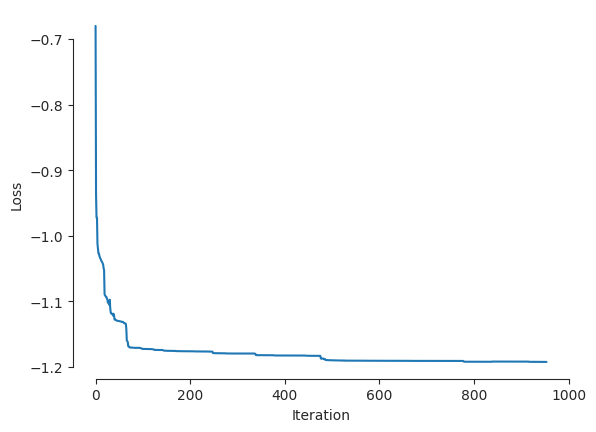

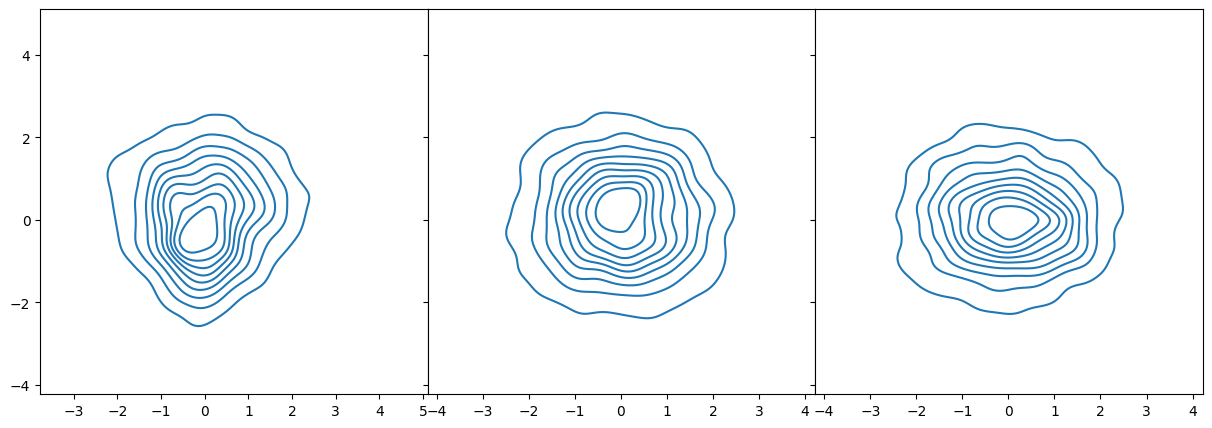

In [24]:
set_seeds(9)

y, train_likelihood = create_data(2000)

nl="bounding"

nf_mctm = NF_MCTM(input_min=y.min(0).values,
                  input_max=y.max(0).values,
                  polynomial_range=torch.tensor([[-4], [4]]),
                  number_variables=3,
                  spline_decorrelation="bspline",
                  normalisation_layer=nl)

#no epochs required
start = time.time()
train(model=nf_mctm,
      train_data=y,
      learning_rate=0.4,
      iterations=10000,
      patience=10,
      min_delta=1e-6,
      verbose=False)
end = time.time()

print(end-start)

z = nf_mctm.forward(y,train=False).detach().numpy()

res_normal, res_pval, z_mean, z_cov, p = evaluate_latent_space(z)
print(res_normal)
print(res_pval)
print(z_mean)
print(z_cov)
print(p)


fig = plot_latent_space(z)
print(fig)

100%|██████████| 10000/10000 [13:22<00:00, 12.45it/s]


803.0645802021027
False
0.033314587023725487
[0.00679615 0.00163868 0.00076862]
[[ 9.93335835e-01  1.16234064e-03  4.68300504e-04]
 [ 1.16234064e-03  9.59119486e-01 -1.08072537e-03]
 [ 4.68300504e-04 -1.08072537e-03  9.95735668e-01]]
[0.60362847 0.43915351 0.56582873]
Figure(1500x500)


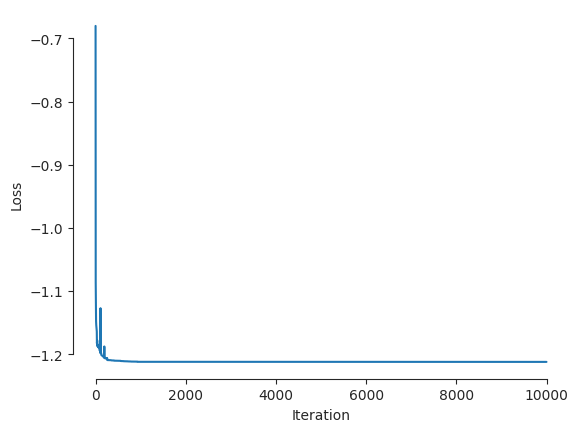

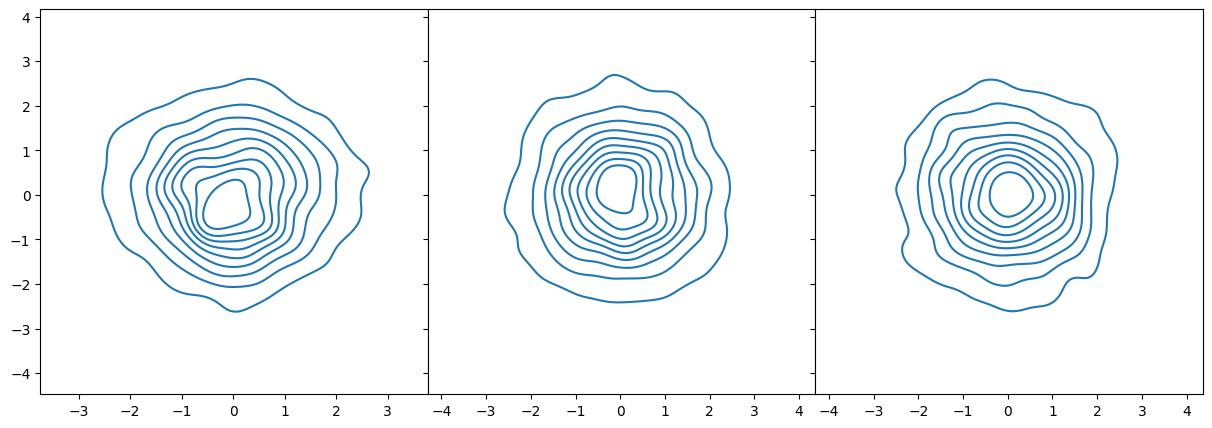

In [7]:
set_seeds(9)

y, train_likelihood = create_data(2000)

nl="bounding"

nf_mctm = NF_MCTM(input_min=y.min(0).values,
                  input_max=y.max(0).values,
                  polynomial_range=torch.tensor([[-4], [4]]),
                  number_variables=3,
                  degree_transformations=5,
                  degree_decorrelation=5,
                  spline_decorrelation="bspline",
                  normalisation_layer=nl)

#no epochs required
start = time.time()
train(model=nf_mctm,
      train_data=y,
      learning_rate=0.4,
      iterations=10000,
      patience=10,
      min_delta=1e-6,
      verbose=False)
end = time.time()

print(end-start)

z = nf_mctm.forward(y,train=False).detach().numpy()

res_normal, res_pval, z_mean, z_cov, p = evaluate_latent_space(z)
print(res_normal)
print(res_pval)
print(z_mean)
print(z_cov)
print(p)


fig = plot_latent_space(z)
print(fig)

In [8]:
stop

NameError: name 'stop' is not defined

In [ ]:
wandb.login()

In [ ]:
sweep_config = {
    "name": "first",
    'method': 'grid'
    }
#metric = {
#    'name': 'loss',
#    'goal': 'minimize'
#    }
#sweep_config['metric'] = metric

In [ ]:
parameters_dict = {
    'normalisation_layer': {
        'values': [None, "bounding"]
      },
    'seed': {
        'values': [1,2,3,4,5,6,7,8,9,10]
      }
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="simulation-study")

In [ ]:
wandb.agent(sweep_id, simulation_study)

In [ ]:
wandb.finish()